In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_decision_forests as tfdf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import svm

/Users/ericwang/Library/Python/3.9/lib/python/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

df = pd.read_csv('./predict-student-performance-from-game-play/train.csv', dtype=dtypes)
print("Full train dataset shape is {}".format(df.shape))

Full train dataset shape is (26296946, 20)


In [6]:
# Display the first 5 examples
df.head(5)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [7]:
#Loading the training labels which states whether a person answered the question correctly in a session
labels = pd.read_csv('./predict-student-performance-from-game-play/train_labels.csv')

In [8]:
#Each session id consists of both session number and the question number which are separated by a '-'
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

'There are more right values than there are wrong ones'

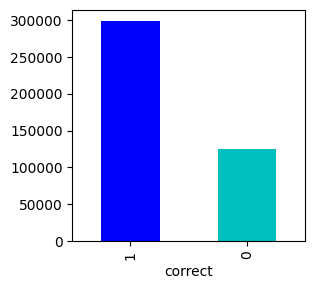

In [9]:
plt.figure(figsize=(3, 3))
plot_df = labels.correct.value_counts()
plot_df.plot(kind="bar", color=['b', 'c'])

'''There are more right values than there are wrong ones'''

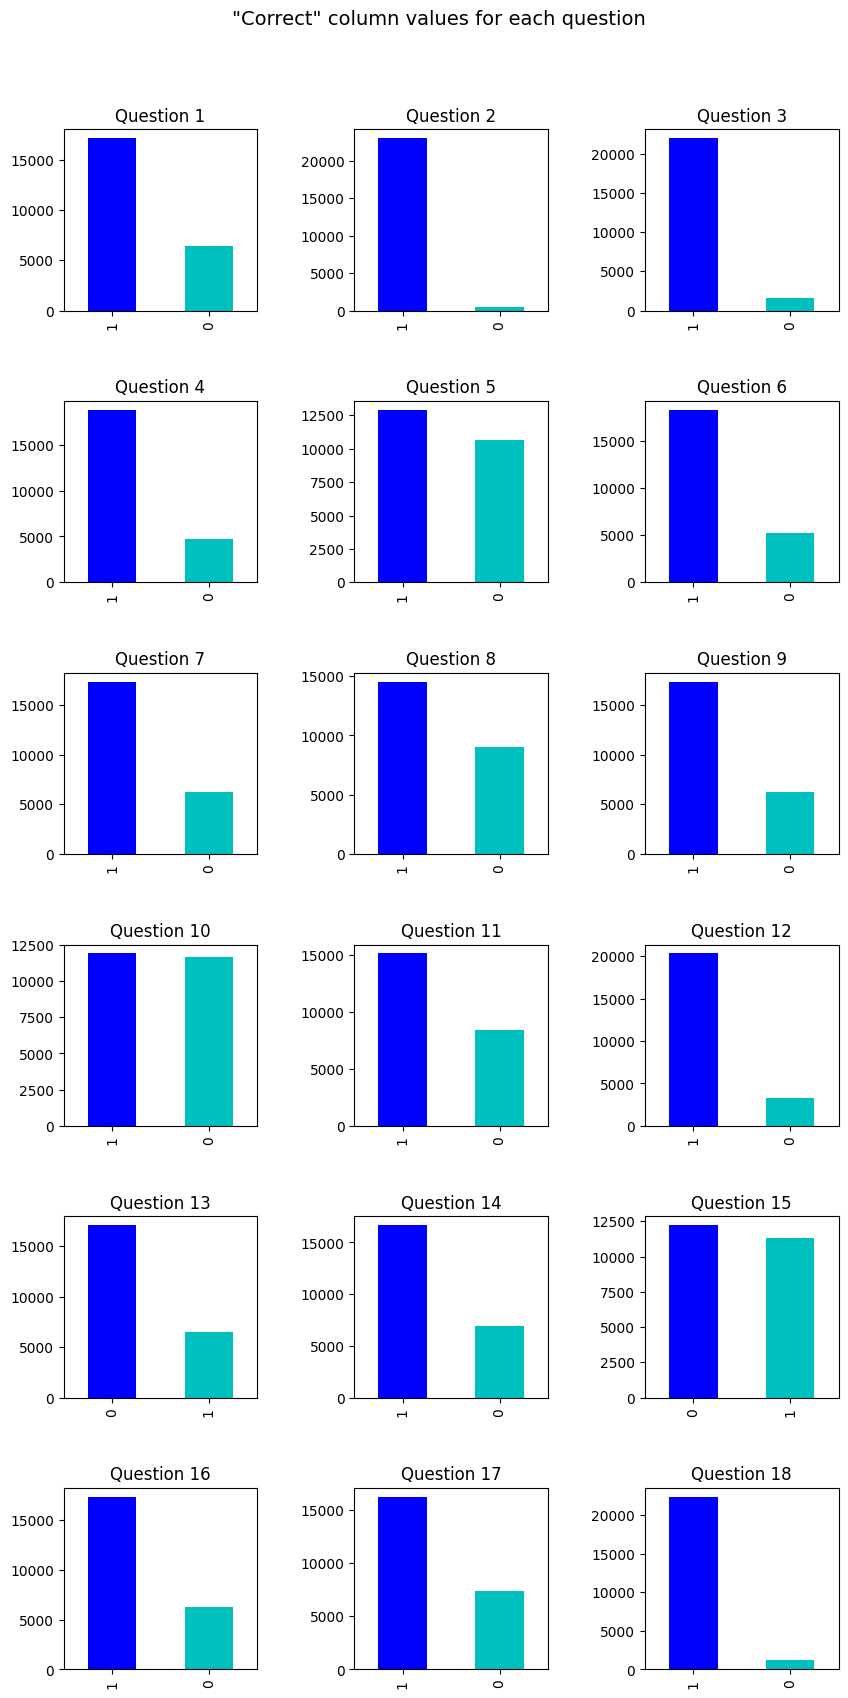

In [7]:
#  We are plotting the correct percentage of each question

plt.figure(figsize=(10, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("\"Correct\" column values for each question", fontsize=14, y=0.94)
for n in range(1,19):
    #print(n, str(n))
    ax = plt.subplot(6, 3, n)

    # filter df and plot ticker on the new subplot axis
    plot_df = labels.loc[labels.q == n]
    plot_df = plot_df.correct.value_counts()
    plot_df.plot(ax=ax, kind="bar", color=['b', 'c'])
    
    # chart formatting
    ax.set_title("Question " + str(n))
    ax.set_xlabel("")


#### As we observe from the charts above, Qn 5, 10 and 15 are the worst performing questions in this set

In [12]:
#We want to split the categorical columns to the numerical ones 
# such that we would be able to process them accordingly

CAT = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUM = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

#For both these set of variables, we would group the dataset byu their session_id and the
#level_group. The main difference is that for the numerical group we would calculate their
# mean and std dev, while for the categorical we would just take the distinct count of elements

In [13]:
def feature_engineering(df):
    dfs =[]
    for c in CAT:
        temp = df.groupby(['session_id','level_group'])[c].agg('nunique')
        temp.name = temp.name+'_nunique'
        dfs.append(temp)
    for c in NUM:
        temp = df.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(temp)
    for c in NUM:
        temp = df.groupby(['session_id','level_group'])[c].agg('std')
        temp.name = temp.name + '_std'
        dfs.append(temp)
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [14]:
df = feature_engineering(df)
# used for actual prediction
data = df.copy()
data['new_feature'] = 0
df = df.reset_index()
df['correct'] = 0
print(f'Shape of prepared dataset: {df.shape}')

Shape of prepared dataset: (70686, 25)


In [16]:
data

,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std,correct,new_feature
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.000000,7.701275,...,4.924654e+04,1.230975,-1.000000,399.296038,129.292411,214.871000,104.082743,3227.370757,0,0
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.000000,-130.347168,...,1.266661e+05,2.358652,-1.000000,622.061374,230.370874,240.280218,99.067861,1305.088265,0,0
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.000000,14.306062,...,8.017568e+04,2.096919,-1.000000,357.227701,137.409476,203.268560,120.255453,1316.408315,0,0
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.000000,-84.045959,...,6.737271e+04,1.232616,0.000000,445.980041,156.186242,252.554707,121.062929,2114.876406,0,0
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.100000,-30.762283,...,7.773825e+05,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100219442786200,13-22,11,4,49,12,33,9.619192e+05,17.671395,5.230769,-158.599121,...,1.516019e+05,2.359474,0.908083,589.562720,273.090325,248.584999,134.772721,1675.299532,0,0
22100219442786200,5-12,11,6,41,11,20,3.866058e+05,8.111511,1.833333,-2.569204,...,9.665042e+04,2.180934,0.923548,390.345335,147.579436,250.827193,135.693654,1910.823123,0,0
22100221145014656,0-4,11,4,27,7,17,2.036104e+05,2.061611,0.333333,-1.339606,...,1.085422e+05,1.276526,0.516398,392.539487,159.619091,213.638122,128.499750,6725.520698,0,0


In [11]:
df.head(5)

,session_id,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,...,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std,correct,new_feature
0,20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,...,49246.539458,1.230975,-1.000000,399.296038,129.292411,214.871000,104.082743,3227.370757,0,0
1,20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,...,126666.129584,2.358652,-1.000000,622.061374,230.370874,240.280218,99.067861,1305.088265,0,0
2,20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,...,80175.676658,2.096919,-1.000000,357.227701,137.409476,203.268560,120.255453,1316.408315,0,0
3,20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,...,67372.714092,1.232616,0.000000,445.980041,156.186242,252.554707,121.062929,2114.876406,0,0
4,20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,...,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518,0,0


In [12]:
labels.head(10)

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1
5,20090314035813970_q1,1,20090314035813970,1
6,20090314121766812_q1,1,20090314121766812,1
7,20090314221187252_q1,0,20090314221187252,1
8,20090314363702160_q1,1,20090314363702160,1
9,20090314441803444_q1,1,20090314441803444,1


# Data Engineering

In [15]:
# Function checks if the key exists in the dictionary
def check_key(key, dict):
    if key in dict:
        return True
    else:
        return False
    
 # Function updates the 'correct' and 'count' values in the dictionary with corresponding key
def update_correct(key, val, dict):
   dict[key]['correct'] += val
   dict[key]['count'] += 1
   return dict

In [16]:
# Function: For each session, it compresses all data within level_group with the same key and stores it in a dictionary where the key is the session_id 
# and the value is a dictionary with number of correct and how many observations of key is in the dictionary.
# Example: bin1: {20090312431273200: {'correct':4, 'count':5, 'q':2}} -> dataframe['correct'] = 4/5
# Example: bin2: {20090312431273200: {'correct':3, 'count':3, 'q':6}} -> dataframe['correct'] = 3/3

def compress_label(labels):
    bin1 = {}
    bin2 = {}
    bin3 = {}

    for i in range(0, len(labels)):
        # checks bin1 if q <= 4
        if labels['q'].loc[i] <= 4:
            # if the session, a key, exists in bin1 we update the key-value
            if check_key(labels['session'].loc[i], bin1) == True:
                update_correct(labels['session'].loc[i], labels['correct'].loc[i], bin1)
            # if it doesn't exist, we create a new key-value pair in bin1
            else:
                bin1[labels['session'].loc[i]] = {'correct':labels['correct'].loc[i], 'count':1}

        # checks bin2 if 5<= q <= 12
        elif 5<= labels['q'].loc[i] <= 12:
            # if the session, a key, exists in bin2 we update the key-value
            if check_key(labels['session'].loc[i], bin2) == True:
                update_correct(labels['session'].loc[i], labels['correct'].loc[i], bin2)
            # if it doesn't exist, we create a new key-value pair in bin2
            else:
                bin2[labels['session'].loc[i]] = {'correct':labels['correct'].loc[i], 'count':1}
        
        # checks bin3 if q >= 13
        else:
            # if the session, a key, exists in bin3 we update the key-value
            if check_key(labels['session'].loc[i], bin3) == True:
                update_correct(labels['session'].loc[i], labels['correct'].loc[i], bin3)
            # if it doesn't exist, we create a new key-value pair in bin1
            else:
                bin3[labels['session'].loc[i]] = {'correct':labels['correct'].loc[i], 'count':1}
    return bin1, bin2, bin3

In [17]:
# Function merges values in each of the three bins with the data frame accordingly
def merge_labels(b1, b2, b3, dataframe):
    # for every observation in data frame, we store the session_id as key
    for i in range(0, len(dataframe)):
        key = dataframe['session_id'].loc[i]
        # if the level group is 0-4, we store correct/count in the correct column of the data frame from bin1
        if dataframe['level_group'].loc[i] == '0-4':
            dataframe['correct'].loc[i] = b1[key]['correct']/b1[key]['count']
        # if the level group is 5-12... bin2
        elif dataframe['level_group'].loc[i] == '5-12':
            dataframe['correct'].loc[i] = b2[key]['correct']/b2[key]['count']
        # else... bin3
        else:
            dataframe['correct'].loc[i] = b3[key]['correct']/b3[key]['count']
    return dataframe

In [18]:
bin1, bin2, bin3 = compress_label(labels)
merge_labels(bin1, bin2, bin3, df)

/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/1862425998.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['correct'].loc[i] = b1[key]['correct']/b1[key]['count']
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/1862425998.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['correct'].loc[i] = b3[key]['correct']/b3[key]['count']


,session_id,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,...,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std,correct,new_feature
0,20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.000000,...,4.924654e+04,1.230975,-1.000000,399.296038,129.292411,214.871000,104.082743,3227.370757,1.000000,0
1,20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.000000,...,1.266661e+05,2.358652,-1.000000,622.061374,230.370874,240.280218,99.067861,1305.088265,0.666667,0
2,20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.000000,...,8.017568e+04,2.096919,-1.000000,357.227701,137.409476,203.268560,120.255453,1316.408315,1.000000,0
3,20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.000000,...,6.737271e+04,1.232616,0.000000,445.980041,156.186242,252.554707,121.062929,2114.876406,0.750000,0
4,20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.100000,...,7.773825e+05,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518,0.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70681,22100219442786200,13-22,11,4,49,12,33,9.619192e+05,17.671395,5.230769,...,1.516019e+05,2.359474,0.908083,589.562720,273.090325,248.584999,134.772721,1675.299532,0.666667,0
70682,22100219442786200,5-12,11,6,41,11,20,3.866058e+05,8.111511,1.833333,...,9.665042e+04,2.180934,0.923548,390.345335,147.579436,250.827193,135.693654,1910.823123,0.750000,0
70683,22100221145014656,0-4,11,4,27,7,17,2.036104e+05,2.061611,0.333333,...,1.085422e+05,1.276526,0.516398,392.539487,159.619091,213.638122,128.499750,6725.520698,0.500000,0
70684,22100221145014656,13-22,11,4,54,13,36,4.899580e+06,18.127632,5.181818,...,3.370855e+05,2.210473,0.906924,566.855306,249.156178,232.192779,122.521568,1115.700943,0.333333,0


In [19]:
y = df['correct']
x = df.drop(columns=['correct', 'level_group', 'session_id'])
x = SelectKBest(f_classif, k=3).fit_transform(x,y)

/Users/ericwang/Library/Python/3.9/lib/python/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [21] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/ericwang/Library/Python/3.9/lib/python/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [20]:
regressor = svm.SVR()
regressor.fit(x,y)
t = regressor.predict(x)

In [21]:
data['new_feature'] = t

In [22]:
df.head(5)

,session_id,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,...,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std,correct,new_feature
0,20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,...,49246.539458,1.230975,-1.000000,399.296038,129.292411,214.871000,104.082743,3227.370757,1.000000,0
1,20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,...,126666.129584,2.358652,-1.000000,622.061374,230.370874,240.280218,99.067861,1305.088265,0.666667,0
2,20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,...,80175.676658,2.096919,-1.000000,357.227701,137.409476,203.268560,120.255453,1316.408315,1.000000,0
3,20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,...,67372.714092,1.232616,0.000000,445.980041,156.186242,252.554707,121.062929,2114.876406,0.750000,0
4,20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,...,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518,0.500000,0


In [23]:
data.head()

,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std,correct,new_feature
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,7.701275,...,49246.539458,1.230975,-1.000000,399.296038,129.292411,214.871000,104.082743,3227.370757,0,0.902904
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,-130.347168,...,126666.129584,2.358652,-1.000000,622.061374,230.370874,240.280218,99.067861,1305.088265,0,0.640357
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,14.306062,...,80175.676658,2.096919,-1.000000,357.227701,137.409476,203.268560,120.255453,1316.408315,0,0.724840
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,-84.045959,...,67372.714092,1.232616,0.000000,445.980041,156.186242,252.554707,121.062929,2114.876406,0,0.898030
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,-30.762283,...,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518,0,0.563114


### Splitting Dataset

In [24]:
def split_dataset(dataset, test_ratio=0.20):
    USER_LIST = dataset.index.unique()
    split = int(len(USER_LIST) * (1 - 0.20))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]

train_x, test_x = split_dataset(data)
print("{} examples in training, {} examples in testing.".format(
    len(train_x), len(test_x)))

56547 examples in training, 14139 examples in testing.


In [25]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

To get started, we'll work with a Gradient Boosted Trees Model. This is one of the well-known Decision Forest training algorithms.

A Gradient Boosted Decision Tree is a set of shallow decision trees trained sequentially. Each tree is trained to predict and then "correct" for the errors of the previously trained trees.

# How can I configure a tree-based model?

TensorFlow Decision Forests provides good defaults for you (e.g., the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get the highest possible accuracy.

You can select a template and/or set parameters as follows:
```
rf = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
```

You can read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/GradientBoostedTreesModel).

# Training


We will train a model for each question to predict if the question will be answered correctly by a user. 
There are a total of 18 questions in the dataset. Hence, we will be training 18 models, one for each question.

We need to provide a few data structures to our training loop to store the trained models, predictions on the validation set and evaluation scores for the trained models.

We will create these using the following code:


In [26]:
# Fetch the unique list of user sessions in the validation dataset. We assigned 
# `session_id` as the index of our feature engineered dataset. Hence fetching 
# the unique values in the index column will give us a list of users in the 
# validation set.
VALID_USER_LIST = test_x.index.unique()

# Create a dataframe for storing the predictions of each question for all users
# in the validation set.
# For this, the required size of the data frame is: 
# (no: of users in validation set  x no of questions).
# We will initialize all the predicted values in the data frame to zero.
# The dataframe's index column is the user `session_id`s. 
prediction_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)

# Create an empty dictionary to store the models created for each question.
models = {}

# Create an empty dictionary to store the evaluation score for each question.
evaluation_dict ={}

In [45]:
prediction_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
session_id,,,,,,,,,,,,,,,,,,
22000320020067784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22000321083750010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22000401381351532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22000407142860316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22000407572357990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100215342220508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22100215460321130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22100217104993650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Iterate through questions 1 to 18 to train models for each question, evaluate
# the trained model and store the predicted values.
for q_no in range(1,19):

    # Select level group for the question based on the q_no.
    if q_no<=3: grp = '0-4'
    elif q_no<=13: grp = '5-12'
    elif q_no<=22: grp = '13-22'
    print("### q_no", q_no, "grp", grp)
    
        
    # Filter the rows in the datasets based on the selected level group. 
    train_df = train_x.loc[train_x.level_group == grp]
    train_users = train_df.index.values
    valid_df = test_x.loc[test_x.level_group == grp]
    valid_users = valid_df.index.values

    # Select the labels for the related q_no.
    train_labels = labels.loc[labels.q==q_no].set_index('session').loc[train_users]
    valid_labels = labels.loc[labels.q==q_no].set_index('session').loc[valid_users]

    # Add the label to the filtered datasets.
    train_df["correct"] = train_labels["correct"]
    valid_df["correct"] = valid_labels["correct"]

    # There's one more step required before we can train the model. 
    # We need to convert the datatset from Pandas format (pd.DataFrame)
    # into TensorFlow Datasets format (tf.data.Dataset).
    # TensorFlow Datasets is a high performance data loading library 
    # which is helpful when training neural networks with accelerators like GPUs and TPUs.
    # We are omitting `level_group`, since it is not needed for training anymore.
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df.loc[:, train_df.columns != 'level_group'], label="correct")
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df.loc[:, valid_df.columns != 'level_group'], label="correct")

    # We will now create the Gradient Boosted Trees Model with default settings. 
    # By default the model is set to train for a classification task.
    gbtm = tfdf.keras.RandomForestModel(verbose=0)
    gbtm.compile(metrics=["accuracy"])

    # Train the model.
    gbtm.fit(x=train_ds)

    # Store the model
    models[f'{grp}_{q_no}'] = gbtm

    # Evaluate the trained model on the validation dataset and store the 
    # evaluation accuracy in the `evaluation_dict`.
    inspector = gbtm.make_inspector()
    inspector.evaluation()
    evaluation = gbtm.evaluate(x=valid_ds,return_dict=True)
    evaluation_dict[q_no] = evaluation["accuracy"]         

    # Use the trained model to make predictions on the validation dataset and 
    # store the predicted values in the `prediction_df` dataframe.
    predict = gbtm.predict(x=valid_ds)
    prediction_df.loc[valid_users, q_no-1] = predict.flatten()     

### q_no 1 grp 0-4


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
2023-05-09 14:24:47.909528: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
[INFO 23-05-09 14:24:50.9250 EDT kernel.cc

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5/5 [==============================] - 0s 32ms/step
### q_no 2 grp 0-4


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-09 14:24:55.1562 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmp7eydy2gt/model/ with prefix 1599c932d

5/5 [==============================] - 0s 24ms/step
### q_no 3 grp 0-4


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-09 14:24:58.1707 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpjrqfl6ta/model/ with prefix 1b6afafb4

5/5 [==============================] - 0s 29ms/step
### q_no 4 grp 5-12


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-09 14:25:01.8274 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmp5z6r7eia/model/ with prefix c68942b18

5/5 [==============================] - 0s 30ms/step
### q_no 5 grp 5-12


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


[INFO 23-05-09 14:25:06.1410 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpp4dmj58r/model/ with prefix f70892587483430f
[INFO 23-05-09 14:25:07.0031 EDT decision_forest.cc:660] Model loaded with 300 root(s), 677886 node(s), and 22 input feature(s).
[INFO 23-05-09 14:25:07.0032 EDT kernel.cc:1074] Use fast generic engine


5/5 [==============================] - 0s 42ms/step
### q_no 6 grp 5-12


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]


[INFO 23-05-09 14:25:10.8576 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpxvycbcq0/model/ with prefix 00b729144efd4c13
[INFO 23-05-09 14:25:11.6335 EDT decision_forest.cc:660] Model loaded with 300 root(s), 589458 node(s), and 22 input feature(s).
[INFO 23-05-09 14:25:11.6335 EDT kernel.cc:1074] Use fast generic engine


5/5 [==============================] - 0s 34ms/step
### q_no 7 grp 5-12


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-09 14:25:15.3947 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmp_b2rel_a/model/ with prefix 5ccfb2c40

5/5 [==============================] - 0s 36ms/step
### q_no 8 grp 5-12


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-09 14:25:19.7468 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpx7n78k9e/model/ with prefix 0a41f917b

5/5 [==============================] - 0s 32ms/step
### q_no 9 grp 5-12


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-09 14:25:23.9720 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpfpp_sy7c/model/ with prefix fd896e798

5/5 [==============================] - 0s 32ms/step
### q_no 10 grp 5-12


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-09 14:25:28.3011 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmphwz23u0v/model/ with prefix 5ea118fb0

5/5 [==============================] - 0s 35ms/step
### q_no 11 grp 5-12


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-09 14:25:32.4858 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmp1p0drv26/model/ with prefix 18de024c4

5/5 [==============================] - 0s 31ms/step
### q_no 12 grp 5-12


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-09 14:25:36.4412 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpkci46a3m/model/ with prefix bffd13208

5/5 [==============================] - 0s 30ms/step
### q_no 13 grp 5-12


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-09 14:25:40.3743 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmp_woetqds/model/ with prefix 6eef1a840

5/5 [==============================] - 0s 32ms/step
### q_no 14 grp 13-22


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-09 14:25:44.6262 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpb1c95eip/model/ with prefix 6afaed499

5/5 [==============================] - 0s 31ms/step
### q_no 15 grp 13-22


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-09 14:25:49.0217 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmphcfqgyyf/model/ with prefix af00c4ad9

5/5 [==============================] - 0s 32ms/step
### q_no 16 grp 13-22


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-09 14:25:52.9824 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmpa1brsjkj/model/ with prefix 4ce2ebefa

5/5 [==============================] - 0s 32ms/step
### q_no 17 grp 13-22


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-09 14:25:56.7135 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmptmjj0wnx/model/ with prefix d3dd8a53b

5/5 [==============================] - 0s 32ms/step
### q_no 18 grp 13-22


/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/ipykernel_33869/2592180891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[INFO 23-05-09 14:26:00.1819 EDT kernel.cc:1242] Loading model from path /var/folders/hb/vc7g33x55zj491kqzxj0jdm80000gn/T/tmp1bf772nj/model/ with prefix bb530664e

5/5 [==============================] - 0s 25ms/step


In [28]:
for name, value in evaluation_dict.items():
  print(f"question {name}: accuracy {value:.4f}")

print("\nAverage accuracy", sum(evaluation_dict.values())/18)

question 1: accuracy 0.7318
question 2: accuracy 0.9756
question 3: accuracy 0.9351
question 4: accuracy 0.7931
question 5: accuracy 0.6289
question 6: accuracy 0.7895
question 7: accuracy 0.7464
question 8: accuracy 0.6363
question 9: accuracy 0.7670
question 10: accuracy 0.6026
question 11: accuracy 0.6556
question 12: accuracy 0.8697
question 13: accuracy 0.7199
question 14: accuracy 0.7339
question 15: accuracy 0.6015
question 16: accuracy 0.7490
question 17: accuracy 0.7036
question 18: accuracy 0.9516

Average accuracy 0.7550746136241488


In [30]:
tfdf.model_plotter.plot_model_in_colab(models['0-4_1'], tree_idx=0, max_depth=3)

In [31]:
inspector = models['0-4_1'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 SUM_SCORE
	 NUM_NODES


In [32]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

[("room_fqid_nunique" (1; #17), 67.0),
 ("name_nunique" (1; #9), 58.0),
 ("page_std" (1; #12), 43.0),
 ("page" (1; #11), 40.0),
 ("elapsed_time" (1; #1), 22.0),
 ("event_name_nunique" (1; #3), 21.0),
 ("new_feature" (1; #10), 18.0),
 ("elapsed_time_std" (1; #2), 15.0),
 ("level" (1; #7), 7.0),
 ("level_std" (1; #8), 4.0),
 ("screen_coor_y_std" (1; #21), 2.0),
 ("fqid_nunique" (1; #4), 1.0),
 ("room_coor_y_std" (1; #16), 1.0),
 ("text_fqid_nunique" (1; #22), 1.0)]

In [33]:
# Create a dataframe of required size:
# (no: of users in validation set x no: of questions) initialized to zero values
# to store true values of the label `correct`. 
true_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)
for i in range(18):
    # Get the true labels.
    tmp = labels.loc[labels.q == i+1].set_index('session').loc[VALID_USER_LIST]
    true_df[i] = tmp.correct.values

max_score = 0; best_threshold = 0

# Loop through threshold values from 0.4 to 0.8 and select the threshold with 
# the highest `F1 score`.
for threshold in np.arange(0.4,0.8,0.01):
    metric = tfa.metrics.F1Score(num_classes=2,average="macro",threshold=threshold)
    y_true = tf.one_hot(true_df.values.reshape((-1)), depth=2)
    y_pred = tf.one_hot((prediction_df.values.reshape((-1))>threshold).astype('int'), depth=2)
    metric.update_state(y_true, y_pred)
    f1_score = metric.result().numpy()
    if f1_score > max_score:
        max_score = f1_score
        best_threshold = threshold
        
print("Best threshold ", best_threshold, "\tF1 score ", max_score)

Best threshold  0.7200000000000003 	F1 score  0.6726184


# Test